In [3]:
!pip install nflreadpy

In [4]:
## Load Python Libraries
import pandas as pd
import numpy as np
import nflreadpy as nfl
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [15]:
# 1.1 Load and Prepare Data

# Parameters
team = "IND"
season = 2025

# Load schedules
sched = nfl.load_schedules([season])

# Find Colts game 1
colts_g1 = sched.filter(
    (sched['game_type'] == 'REG') &
    (sched['season'] == season) &
    ((sched['home_team'] == team) | (sched['away_team'] == team))
).sort(['gameday', 'week']).row(0, named=True) # Use row(0, named=True) to get the first row as a named dict


# Extract game information
game_id = colts_g1['game_id']
week = colts_g1['week']
gameday = colts_g1['gameday']
home_tm = colts_g1['home_team']
away_tm = colts_g1['away_team']
opp = away_tm if home_tm == team else home_tm

print(f"Found Colts Week {week} ({gameday}): {away_tm} @ {home_tm} | game_id = {game_id}")

## Load Play-by-Play, Rosters, and Officials Data

# Load play-by-play data
pbp_g1 = nfl.load_pbp([season])
pbp_g1 = pbp_g1.filter(pbp_g1['game_id'] == game_id).to_pandas() # Use filter and convert to pandas for compatibility with downstream code


# Load weekly rosters
rw_g1 = nfl.load_rosters_weekly([season])
rw_g1 = rw_g1.filter((rw_g1['week'] == week) & (rw_g1['team'].is_in([team, opp]))).to_pandas() # Use filter and convert to pandas


# Load officials
try:
    officials_g1 = nfl.load_officials([season])
    officials_g1 = officials_g1.filter(officials_g1['game_id'] == game_id).to_pandas() # Use filter and convert to pandas
except:
    print("Officials data not available")
    officials_g1 = pd.DataFrame()

# Load players master
players_master = nfl.load_rosters([season])

Found Colts Week 1 (2025-09-07): MIA @ IND | game_id = 2025_01_MIA_IND


In [16]:
## 1.2 Data Integrity Check

print("\n--- STRUCTURE ---")
print(f"PBP rows/cols: {pbp_g1.shape[0]}, {pbp_g1.shape[1]}")
print(f"Weekly roster rows/cols: {rw_g1.shape[0]}, {rw_g1.shape[1]}")
print(f"Officials rows/cols: {officials_g1.shape[0]}, {officials_g1.shape[1]}\n")

# Check for duplicate plays
dup_plays = pbp_g1.groupby(['game_id', 'play_id']).size().reset_index(name='n')
dup_plays = dup_plays[dup_plays['n'] > 1]

if len(dup_plays) > 0:
    print(f"Warning: {len(dup_plays)} duplicate plays detected")
else:
    print("Key check passed: (game_id, play_id) appear unique for this game.")

# Check missingness for critical fields
na_summary = pd.DataFrame({
    'na_epa': [pbp_g1['epa'].isna().mean()],
    'na_success': [pbp_g1['success'].isna().mean()],
    'na_posteam': [pbp_g1['posteam'].isna().mean()],
    'na_defteam': [pbp_g1['defteam'].isna().mean()],
    'na_yardline_100': [pbp_g1['yardline_100'].isna().mean()],
    'na_down': [pbp_g1['down'].isna().mean()],
    'na_ydstogo': [pbp_g1['ydstogo'].isna().mean()],
    'na_play_type': [pbp_g1['play_type'].isna().mean()]
})
print("\n--- MISSINGNESS (PBP) ---")
print(na_summary)

# Range checks
bad_yardline = pbp_g1[pbp_g1['yardline_100'].notna() &
                      ((pbp_g1['yardline_100'] < 0) | (pbp_g1['yardline_100'] > 100))]
if len(bad_yardline) > 0:
    print(f"Warning: {len(bad_yardline)} out-of-range yardline_100 values")

print("\n--- TEAM ABBREVS IN PBP ---")
print(sorted(pbp_g1['posteam'].dropna().unique()))
print(sorted(pbp_g1['defteam'].dropna().unique()))


--- STRUCTURE ---
PBP rows/cols: 152, 372
Weekly roster rows/cols: 201, 36
Officials rows/cols: 0, 9

Key check passed: (game_id, play_id) appear unique for this game.

--- MISSINGNESS (PBP) ---
     na_epa  na_success  na_posteam  na_defteam  na_yardline_100   na_down  \
0  0.013158    0.013158    0.065789    0.065789         0.078947  0.171053   

   na_ydstogo  na_play_type  
0         0.0      0.032895  

--- TEAM ABBREVS IN PBP ---
['IND', 'MIA']
['IND', 'MIA']


In [17]:
## 2.1 Create points_scored variable

pbp_g1['points_scored'] = 0
pbp_g1.loc[pbp_g1['touchdown'] == 1, 'points_scored'] = 6
pbp_g1.loc[pbp_g1['field_goal_result'] == 'made', 'points_scored'] = 3
pbp_g1.loc[pbp_g1['safety'] == 1, 'points_scored'] = 2
pbp_g1.loc[pbp_g1['extra_point_result'] == 'good', 'points_scored'] = 1
pbp_g1.loc[(pbp_g1['two_point_attempt'] == 1) &
           (pbp_g1['two_point_conv_result'] == 'success'), 'points_scored'] = 2

In [18]:
## 2.2 Quarter-by-Quarter Scoring

score_by_q = pbp_g1[pbp_g1['qtr'].isin([1,2,3,4])].groupby('qtr').apply(
    lambda x: pd.Series({
        'ind_points': x[x['posteam'] == 'IND']['points_scored'].sum(),
        'opp_points': x[x['posteam'] == opp]['points_scored'].sum(),
        'plays': len(x)
    })
).reset_index()

print("\n--- SCORE BY QUARTER ---")
print(score_by_q)


--- SCORE BY QUARTER ---
   qtr  ind_points  opp_points  plays
0  1.0           3           0     31
1  2.0          17           0     45
2  3.0           3           0     33
3  4.0          10           8     43



--- TEMPO (median sec/play) ---
  posteam  sec_per_play
0     IND          38.5
1     MIA          34.5

--- OFFENSIVE MIX & EFFICIENCY ---
  posteam play_family  plays  epa_per_play  success_rate  yards_per_play  \
2     IND         Run     40      0.138052      0.500000        3.900000   
1     IND        Pass     30      0.433257      0.566667        8.733333   
0     IND       Other     15      0.189872      0.666667        0.000000   
4     MIA        Pass     35     -0.461216      0.371429        3.857143   
5     MIA         Run     12      0.339320      0.583333        6.500000   
3     MIA       Other     10      0.352272      0.777778        0.000000   

      share  
2  0.470588  
1  0.352941  
0  0.176471  
4  0.614035  
5  0.210526  
3  0.175439  


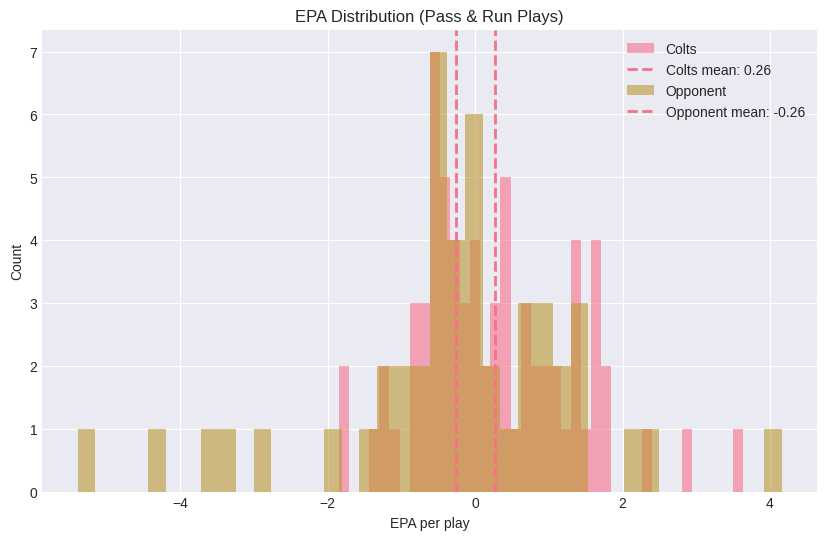

In [19]:
## 2.3 Offensive Play Mix & Efficiency

# Calculate tempo
tempo = pbp_g1[pbp_g1['posteam'].notna() & pbp_g1['game_seconds_remaining'].notna()].copy()
tempo = tempo.sort_values('game_seconds_remaining', ascending=False)
tempo['sec_between'] = tempo.groupby('posteam')['game_seconds_remaining'].diff(-1)
tempo_summary = tempo.groupby('posteam')['sec_between'].median().reset_index()
tempo_summary.columns = ['posteam', 'sec_per_play']
print("\n--- TEMPO (median sec/play) ---")
print(tempo_summary)

# Play mix analysis
def classify_play_family(row):
    if row['play_type'] == 'run':
        return 'Run'
    elif row['play_type'] == 'pass':
        return 'Pass'
    elif row['play_type'] in ['qb_kneel', 'qb_spike']:
        return 'Clock'
    else:
        return 'Other'

pbp_g1['play_family'] = pbp_g1.apply(classify_play_family, axis=1)

off_mix = pbp_g1[pbp_g1['posteam'].notna()].groupby(['posteam', 'play_family']).agg(
    plays=('play_family', 'size'),
    epa_per_play=('epa', 'mean'),
    success_rate=('success', 'mean'),
    yards_per_play=('yards_gained', 'mean')
).reset_index()
off_mix['share'] = off_mix.groupby('posteam')['plays'].transform(lambda x: x / x.sum())
off_mix = off_mix.sort_values(['posteam', 'plays'], ascending=[True, False])

print("\n--- OFFENSIVE MIX & EFFICIENCY ---")
print(off_mix)

# EPA Distribution Plot
fig, ax = plt.subplots(figsize=(10, 6))
epa_data = pbp_g1[(pbp_g1['posteam'].notna()) &
                   (pbp_g1['play_type'].isin(['run', 'pass']))].copy()
epa_data['is_colts'] = epa_data['posteam'].apply(lambda x: 'Colts' if x == 'IND' else 'Opponent')

for team_type in ['Colts', 'Opponent']:
    data = epa_data[epa_data['is_colts'] == team_type]['epa'].dropna()
    ax.hist(data, bins=40, alpha=0.6, label=team_type)
    ax.axvline(data.mean(), linestyle='--', linewidth=2,
               label=f'{team_type} mean: {data.mean():.2f}')

ax.set_xlabel('EPA per play')
ax.set_ylabel('Count')
ax.set_title('EPA Distribution (Pass & Run Plays)')
ax.legend()
plt.show()

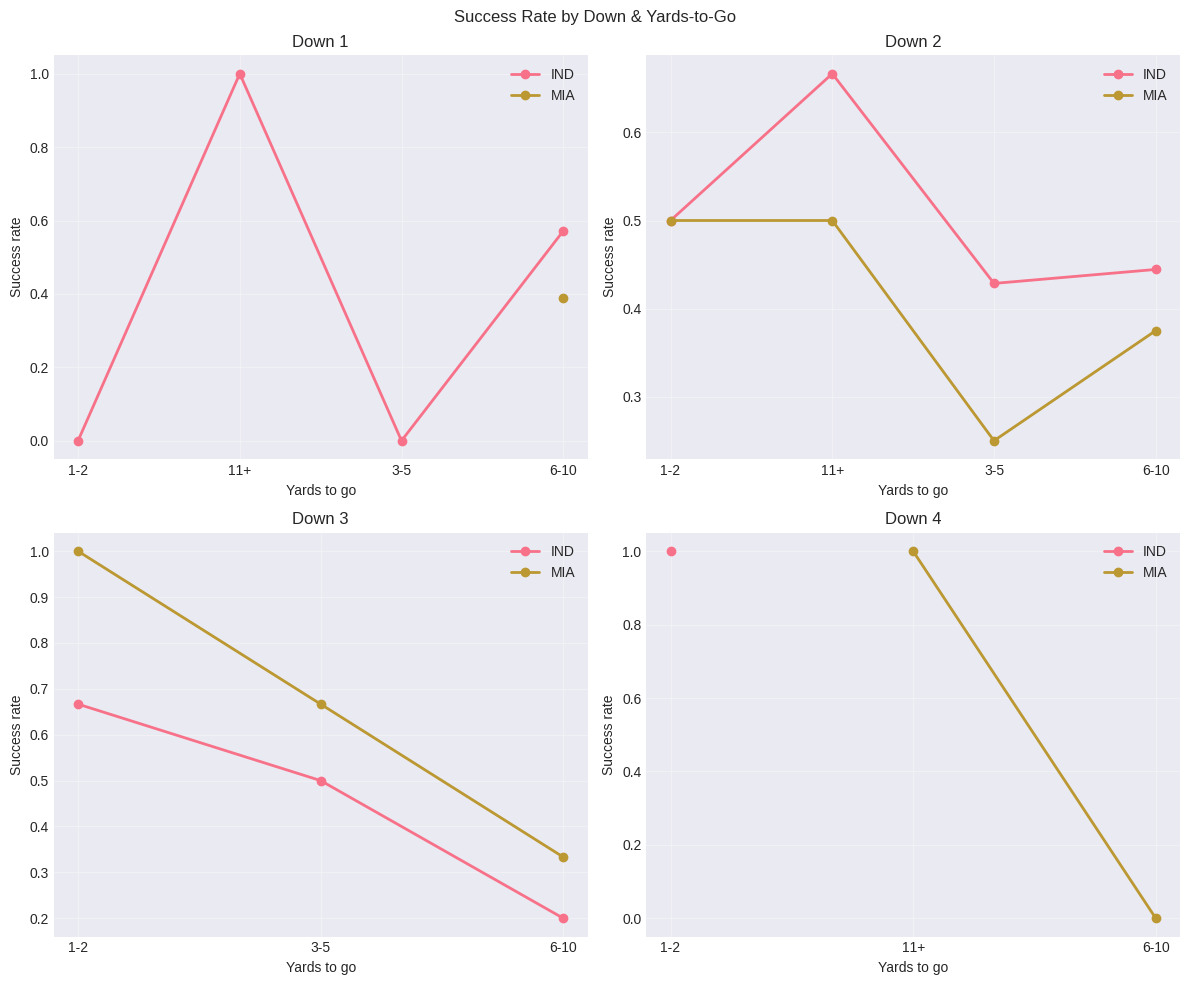

In [20]:
## 2.4 Situational Analysis

def classify_ytg_bucket(ydstogo):
    if ydstogo <= 2:
        return '1-2'
    elif ydstogo <= 5:
        return '3-5'
    elif ydstogo <= 10:
        return '6-10'
    else:
        return '11+'

situ_data = pbp_g1[(pbp_g1['down'].notna()) &
                    (pbp_g1['ydstogo'].notna()) &
                    (pbp_g1['play_type'].isin(['pass', 'run']))].copy()
situ_data['ytg_bucket'] = situ_data['ydstogo'].apply(classify_ytg_bucket)
situ_data['down_lab'] = 'Down ' + situ_data['down'].astype(int).astype(str)

situ = situ_data.groupby(['posteam', 'down_lab', 'ytg_bucket']).agg(
    plays=('play_type', 'size'),
    success_rate=('success', 'mean'),
    epa_per_play=('epa', 'mean')
).reset_index()

# Success rate by down and yards-to-go plot
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for i, down in enumerate(['Down 1', 'Down 2', 'Down 3', 'Down 4']):
    ax = axes[i]
    down_data = situ[situ['down_lab'] == down]

    for team in ['IND', opp]:
        team_data = down_data[down_data['posteam'] == team].sort_values('ytg_bucket')
        if not team_data.empty:
            ax.plot(team_data['ytg_bucket'], team_data['success_rate'],
                   marker='o', label=team, linewidth=2)

    ax.set_title(down)
    ax.set_xlabel('Yards to go')
    ax.set_ylabel('Success rate')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Success Rate by Down & Yards-to-Go')
plt.tight_layout()
plt.show()

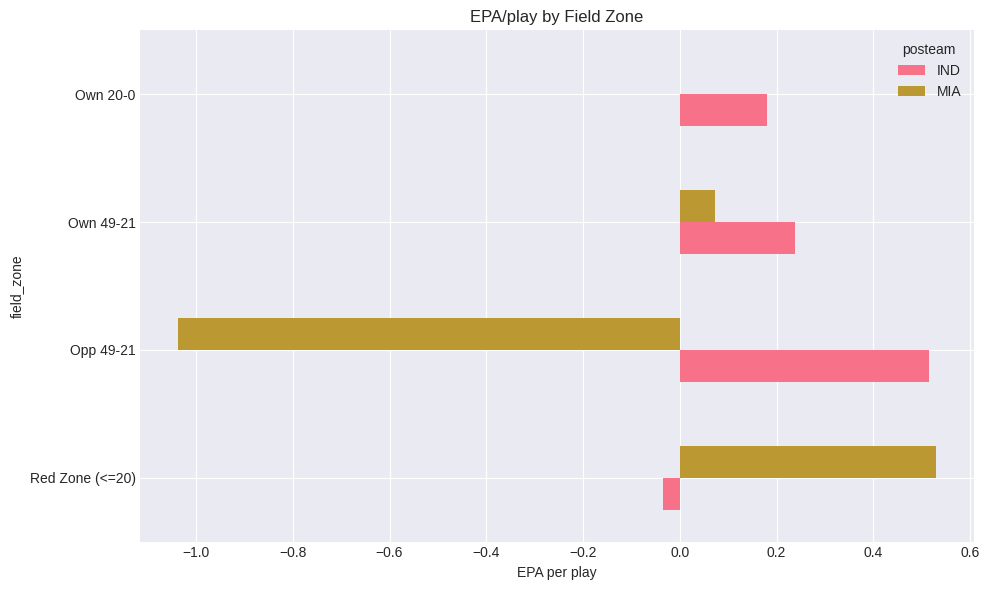

In [21]:
## 2.5 Field Position & Drive Analysis

def classify_field_zone(yardline_100):
    if yardline_100 >= 80:
        return 'Own 20-0'
    elif yardline_100 >= 50:
        return 'Own 49-21'
    elif yardline_100 >= 21:
        return 'Opp 49-21'
    else:
        return 'Red Zone (<=20)'

fieldpos_data = pbp_g1[(pbp_g1['yardline_100'].notna()) &
                        (pbp_g1['play_type'].isin(['run', 'pass']))].copy()
fieldpos_data['field_zone'] = fieldpos_data['yardline_100'].apply(classify_field_zone)

fieldpos = fieldpos_data.groupby(['posteam', 'field_zone']).agg(
    plays=('play_type', 'size'),
    epa_per_play=('epa', 'mean'),
    success_rate=('success', 'mean')
).reset_index()

# EPA by field zone plot
fig, ax = plt.subplots(figsize=(10, 6))
zone_order = ['Red Zone (<=20)', 'Opp 49-21', 'Own 49-21', 'Own 20-0']
fieldpos_plot = fieldpos[fieldpos['posteam'].isin(['IND', opp])]
fieldpos_pivot = fieldpos_plot.pivot(index='field_zone', columns='posteam', values='epa_per_play')
fieldpos_pivot = fieldpos_pivot.reindex(zone_order)
fieldpos_pivot.plot(kind='barh', ax=ax)
ax.set_xlabel('EPA per play')
ax.set_title('EPA/play by Field Zone')
plt.tight_layout()
plt.show()

# Drive summary
drive_sum = pbp_g1[(pbp_g1['drive'].notna()) & (pbp_g1['posteam'].notna())].groupby(['posteam', 'drive']).agg(
    plays=('play_id', 'count'),
    yards=('yards_gained', 'sum'),
    points=('points_scored', 'sum'),
    epa=('epa', 'sum'),
    success_rate=('success', 'mean')
).reset_index()
drive_sum['ended_score'] = drive_sum['points'] > 0
drive_sum = drive_sum.sort_values(['posteam', 'points', 'yards'], ascending=[True, False, False])


Colts Targets:
T.Warren      9
M.Pittman     8
A.Pierce      3
J.Taylor      3
J.Downs       3
A.Mitchell    2
M.Alie-Cox    1
Name: receiver_player_name, dtype: int64

Colts Rush Attempts:
J.Taylor     18
D.Giddens    12
D.Jones       4
T.Warren      1
A.Dulin       1
U.Bentley     1
Name: rusher_player_name, dtype: int64


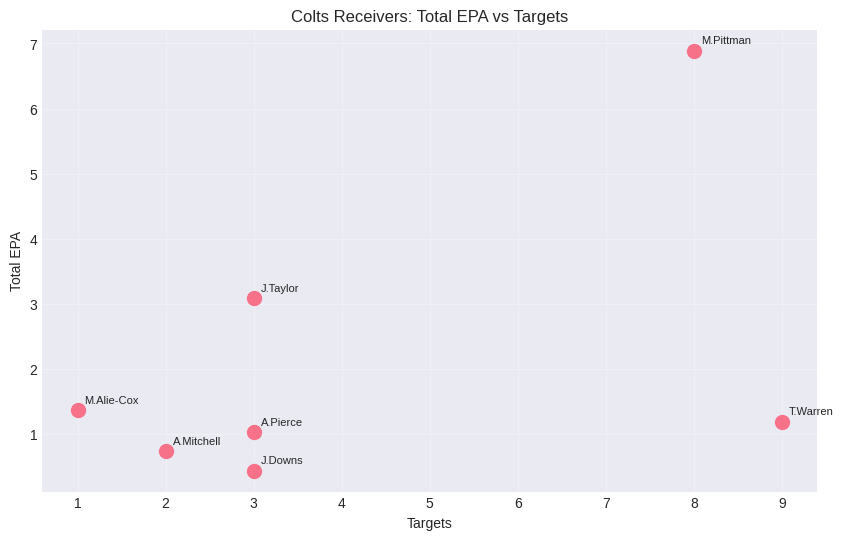


EPA by Receiver:
  receiver_player_name  targets   epa_sum  epa_mean
5            M.Pittman        8  6.890429  0.861304
3             J.Taylor        3  3.088080  1.029360
4           M.Alie-Cox        1  1.361771  1.361771
6             T.Warren        9  1.188942  0.132105
1             A.Pierce        3  1.026512  0.342171
0           A.Mitchell        2  0.729710  0.364855
2              J.Downs        3  0.434468  0.144823

EPA by Rusher:
  rusher_player_name  touches   epa_sum  epa_mean
2            D.Jones        4  3.786742  0.946685
0            A.Dulin        1  1.493579  1.493579
1          D.Giddens       12  0.983128  0.081927
4           T.Warren        1  0.476473  0.476473
3           J.Taylor       18 -0.422080 -0.023449
5          U.Bentley        1 -0.795170 -0.795170


In [25]:
## 2.6 Player Involvement

team = "IND"

# Targets
colts_targets = pbp_g1[(pbp_g1['posteam'] == team) & (pbp_g1['pass'] == 1)]['receiver_player_name'].value_counts()
print("\nColts Targets:")
print(colts_targets.head(10))

# Rush attempts
colts_rushers = pbp_g1[(pbp_g1['posteam'] == team) & (pbp_g1['rush'] == 1)]['rusher_player_name'].value_counts()
print("\nColts Rush Attempts:")
print(colts_rushers.head(10))

# EPA by receiver
epa_by_receiver = pbp_g1[(pbp_g1['posteam'] == team) &
                          (pbp_g1['pass'] == 1) &
                          (pbp_g1['receiver_player_name'].notna())].groupby('receiver_player_name').agg(
    targets=('receiver_player_name', 'size'),
    epa_sum=('epa', 'sum'),
    epa_mean=('epa', 'mean')
).reset_index().sort_values('epa_sum', ascending=False)

# EPA by rusher
epa_by_rusher = pbp_g1[(pbp_g1['posteam'] == team) &
                        (pbp_g1['rush'] == 1) &
                        (pbp_g1['rusher_player_name'].notna())].groupby('rusher_player_name').agg(
    touches=('rusher_player_name', 'size'),
    epa_sum=('epa', 'sum'),
    epa_mean=('epa', 'mean')
).reset_index().sort_values('epa_sum', ascending=False)

# Plot receivers EPA vs targets
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(epa_by_receiver['targets'], epa_by_receiver['epa_sum'], s=100)
for idx, row in epa_by_receiver.iterrows():
    ax.annotate(row['receiver_player_name'],
                (row['targets'], row['epa_sum']),
                xytext=(5, 5), textcoords='offset points', fontsize=8)
ax.set_xlabel('Targets')
ax.set_ylabel('Total EPA')
ax.set_title('Colts Receivers: Total EPA vs Targets')
ax.grid(True, alpha=0.3)
plt.show()

print("\nEPA by Receiver:")
print(epa_by_receiver)
print("\nEPA by Rusher:")
print(epa_by_rusher)

In [26]:
## 2.7 Penalties & Special Teams

# Penalties analysis
penalties = pbp_g1[pbp_g1['penalty'].notna()].copy()
penalties['off_def'] = penalties.apply(
    lambda x: 'Offense' if x['penalty_team'] == x['posteam'] else 'Defense', axis=1
)
penalty_summary = penalties.groupby(['penalty_team', 'off_def', 'penalty_type']).size().reset_index(name='count')
penalty_summary = penalty_summary.sort_values('count', ascending=False)

print("\n--- PENALTIES ---")
print(penalty_summary.head(30))

# Count penalties by team
penalty_count = penalties['penalty_team'].value_counts()
print("\n--- PENALTY COUNT BY TEAM ---")
print(penalty_count)

# Special teams
st_fg = pbp_g1[pbp_g1['play_type'] == 'field_goal'].groupby(['posteam', 'field_goal_result']).size().reset_index(name='count')
st_punt = pbp_g1[pbp_g1['play_type'] == 'punt'].agg(
    punts=('play_type', 'size'),
    avg_punt_yards=('kick_distance', 'mean')
)

print("\n--- SPECIAL TEAMS ---")
print("Field Goals:")
print(st_fg)
print("\nPunts:")
print(st_punt)


--- PENALTIES ---
  penalty_team  off_def                     penalty_type  count
1          IND  Offense                Offensive Holding      3
0          IND  Defense            Unnecessary Roughness      1
2          MIA  Defense                Defensive Holding      1
3          MIA  Defense          Running Into the Kicker      1
4          MIA  Offense  Offensive Too Many Men on Field      1

--- PENALTY COUNT BY TEAM ---
IND    4
MIA    3
Name: penalty_team, dtype: int64

--- SPECIAL TEAMS ---
Field Goals:
  posteam field_goal_result  count
0     IND              made      4

Punts:
                play_type  kick_distance
punts                 1.0            NaN
avg_punt_yards        NaN           42.0


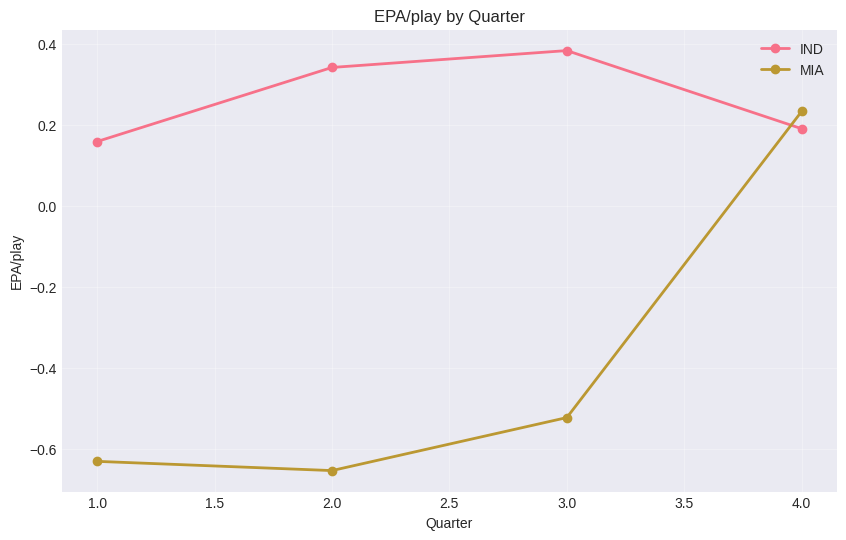

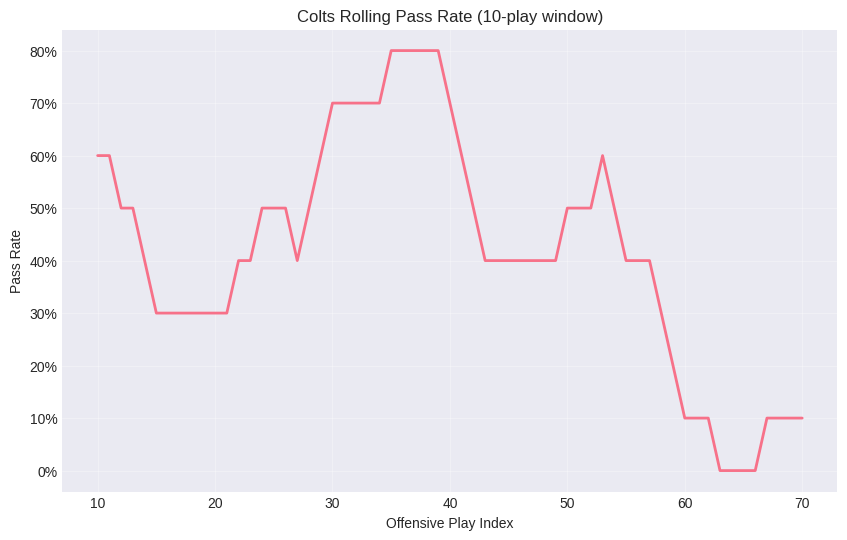

In [31]:
## 2.8 Time-Based Trends

# EPA by quarter
epa_by_q = pbp_g1[(pbp_g1['qtr'].isin([1,2,3,4])) &
                   (pbp_g1['play_type'].isin(['pass', 'run']))].groupby(['posteam', 'qtr']).agg(
    epa_per_play=('epa', 'mean'),
    success_rate=('success', 'mean')
).reset_index()

# Plot EPA by quarter
fig, ax = plt.subplots(figsize=(10, 6))
for team in epa_by_q['posteam'].unique():
    team_data = epa_by_q[epa_by_q['posteam'] == team].sort_values('qtr')
    ax.plot(team_data['qtr'], team_data['epa_per_play'], marker='o', label=team, linewidth=2)
ax.set_xlabel('Quarter')
ax.set_ylabel('EPA/play')
ax.set_title('EPA/play by Quarter')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

# redefines team as IND
team = "IND"

# Rolling pass rate for Colts (10-play window)
colts_seq = pbp_g1[(pbp_g1['posteam'] == team) &
                    (pbp_g1['play_type'].isin(['pass', 'run']))].copy()
colts_seq['play_index'] = range(1, len(colts_seq) + 1)
colts_seq['pass_flag'] = (colts_seq['play_type'] == 'pass').astype(int)

if len(colts_seq) >= 10:
    colts_seq['pass_rate_10'] = colts_seq['pass_flag'].rolling(window=10, min_periods=10).mean()

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(colts_seq['play_index'], colts_seq['pass_rate_10'], linewidth=2)
    ax.set_xlabel('Offensive Play Index')
    ax.set_ylabel('Pass Rate')
    ax.set_title('Colts Rolling Pass Rate (10-play window)')
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    ax.grid(True, alpha=0.3)
    plt.show()

In [33]:
## Compact Summary

# Colts offensive summary
colts_pbp = pbp_g1[pbp_g1['posteam'] == team]

colts_plays = len(colts_pbp)
colts_pass_plays = (colts_pbp['play_type'] == 'pass').sum()
colts_rush_plays = (colts_pbp['play_type'] == 'run').sum()
colts_total_epa = colts_pbp['epa'].sum()
colts_mean_epa = colts_pbp['epa'].mean()
colts_success_rate = colts_pbp['success'].mean()

colts_off = pd.DataFrame({
    'plays': [colts_plays],
    'pass_plays': [colts_pass_plays],
    'rush_plays': [colts_rush_plays],
    'total_epa': [colts_total_epa],
    'mean_epa': [colts_mean_epa],
    'success_rate': [colts_success_rate]
})


# Plays by team and type
plays_by_team_type = pbp_g1[pbp_g1['posteam'].notna()].groupby(['posteam', 'play_type']).size().reset_index(name='count')
plays_by_team_type = plays_by_team_type.sort_values('count', ascending=False)

print("\n--- SUMMARY ---")
print(f"Season: {season}, Week: {week}, Game Day: {gameday}")
print(f"Game: {away_tm} @ {home_tm}")
print(f"Game ID: {game_id}, Opponent for Colts: {opp}")
print(f"\nPBP rows: {len(pbp_g1)}")
print(f"Roster rows: {len(rw_g1)}")
print(f"Officials rows: {len(officials_g1)}")
print("\nTempo (sec/play):")
print(tempo_summary)
print("\nPlays by Team and Type:")
print(plays_by_team_type.head(10))
print("\nColts Offensive Summary:")
print(colts_off)


--- SUMMARY ---
Season: 2025, Week: 1, Game Day: 2025-09-07
Game: MIA @ IND
Game ID: 2025_01_MIA_IND, Opponent for Colts: MIA

PBP rows: 152
Roster rows: 201
Officials rows: 0

Tempo (sec/play):
  posteam  sec_per_play
0     IND          38.5
1     MIA          34.5

Plays by Team and Type:
   posteam    play_type  count
5      IND          run     40
8      MIA         pass     35
4      IND         pass     30
10     MIA          run     12
6      MIA      kickoff      7
1      IND   field_goal      4
3      IND      no_play      4
0      IND  extra_point      3
2      IND      kickoff      2
7      MIA      no_play      1

Colts Offensive Summary:
   plays  pass_plays  rush_plays  total_epa  mean_epa  success_rate
0     85          30          40  21.367863  0.251387      0.552941


## **Question 1: What run location was the most successful for the Colts?**

In [70]:
# Question 1: Run Location
# classify the yards as either lost, gained, or net
def classify_yards_lost(row):
  if row['yards_gained'] < 0:
    return 'Lost'
  elif row['yards_gained'] > 0:
    return 'Gained'
  else:
    return 'Net'

# define runs down the middle as center
pbp_g1['run_gap'] = pbp_g1['run_gap'].astype(str) # Convert to string to allow assignment of 'center'
pbp_g1.loc[pbp_g1['run_location'] == 'middle', 'run_gap'] = 'center'


pbp_g1['yards_lost'] = pbp_g1.apply(classify_yards_lost, axis=1)

run_analysis = pbp_g1[(pbp_g1['play_family'] == 'Run') & (pbp_g1['posteam'] == 'IND')].groupby(['posteam', 'run_location', 'run_gap']).agg(
    plays=('play_family', 'size'),
    epa_per_play=('epa', 'mean'),
    yards_per_play=('yards_gained', 'mean'),
    success_rate=('success', 'mean'),
    yards_lost=('yards_lost', lambda x: (x == 'Lost').sum())
)

run_analysis

plays  epa_per_play  yards_per_play  \
posteam run_location run_gap                                        
IND     left         end          2      0.322856        4.000000   
                     guard        3      0.914539       11.000000   
                     tackle       7     -0.622679        0.285714   
        middle       center      13      0.412619        5.000000   
        right        end          3      0.085175        8.000000   
                     guard        6      0.270460        0.666667   
                     tackle       6     -0.125140        3.333333   

                              success_rate  yards_lost  
posteam run_location run_gap                            
IND     left         end          0.500000           1  
                     guard        1.000000           0  
                     tackle       0.000000           1  
        middle       center       0.692308           0  
        right        end          0.666667           0  
                     guard        0.500000           1  
                     tackle       0.333333           0

## **Question 2: Which receiver averaged the most yards after the catch over expected?**

In [75]:
# Question 2: Yards after Catch Analysis

# Make a new parameters measuring YAC over expected
pbp_g1['YAC_OVER_EXPECTED'] = pbp_g1['yards_after_catch'] - pbp_g1['xyac_median_yardage']

# For all passing plays, find the YAC_OVER_EXPECTED
pass_analysis = pbp_g1[(pbp_g1['play_family'] == 'Pass') & (pbp_g1['posteam'] == 'IND') & (pbp_g1['complete_pass'] == 1)].groupby(['receiver_player_name']).agg(
    catches=('play_family', 'size'),
    avg_yac = ('yards_after_catch', 'mean'),
    avg_yards_over_expected=('YAC_OVER_EXPECTED', 'mean'),
    yac_negative_plays=('YAC_OVER_EXPECTED', lambda x: (x < -1).sum()),
    yac_neutral_plays=('YAC_OVER_EXPECTED', lambda x: ((x >= -1) & (x <= 1)).sum()),
    yac_positive_plays=('YAC_OVER_EXPECTED', lambda x: (x > 1).sum())
).reset_index()

# reorder descending avg yards over expected
pass_analysis = pass_analysis.sort_values('avg_yards_over_expected', ascending=False)

pass_analysis

,receiver_player_name,catches,avg_yac,avg_yards_over_expected,yac_negative_plays,yac_neutral_plays,yac_positive_plays
4,M.Alie-Cox,1,18.000000,14.000000,0,0,1
3,J.Taylor,3,9.666667,3.666667,0,2,1
5,M.Pittman,6,4.333333,2.000000,1,2,3
6,T.Warren,7,5.142857,1.714286,2,3,2
2,J.Downs,2,1.500000,-0.500000,0,2,0
0,A.Mitchell,2,0.000000,-2.500000,2,0,0
1,A.Pierce,1,0.000000,-5.000000,1,0,0
